### Импортируем библиотеки

In [1]:
import pandas as pd
import pandahouse as ph

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230320',
    'user':'student', 
    'password':'dpo_python_2020'
}

### Посчитаем ретеншен пользователей с разным каналом траффика. Сначала с каналом "ads"

In [18]:
query = '''
SELECT 
    toString(start_day) start_day,
    toString(day) day,
    count(user_id) AS users
FROM
  (SELECT user_id,
          min(toDate(time)) AS start_day
    FROM simulator_20230320.feed_actions
    where source = 'ads'
    GROUP BY user_id
    HAVING toMonth(start_day) = 3 and (toDayOfMonth(start_day) BETWEEN 10 and 20)
    ) t1
  JOIN
    (SELECT DISTINCT user_id,
                      toDate(time) AS day
    FROM simulator_20230320.feed_actions
    where source = 'ads' and toMonth(time) < 4
    ) t2 
  USING user_id
GROUP BY start_day, day
'''

In [19]:
df = ph.read_clickhouse(query, connection=connection)

In [20]:
df.head()

,start_day,day,users
0,2023-03-18,2023-03-25,279
1,2023-03-15,2023-03-23,88
2,2023-03-12,2023-03-19,409
3,2023-03-15,2023-03-15,3688
4,2023-03-10,2023-03-27,110


In [21]:
df['start_day'] = pd.to_datetime(df['start_day'])
df['day'] = pd.to_datetime(df['day'])
df['day_n'] = (df['day'] - df['start_day']).dt.days
df.head()

,start_day,day,users,day_n
0,2023-03-18,2023-03-25,279,7
1,2023-03-15,2023-03-23,88,8
2,2023-03-12,2023-03-19,409,7
3,2023-03-15,2023-03-15,3688,0
4,2023-03-10,2023-03-27,110,17


### Создаем сводную таблицу и тепловую карту

In [22]:
pivot = df.pivot_table(index='start_day', columns='day_n', values='users')

<AxesSubplot:xlabel='day_n', ylabel='start_day'>

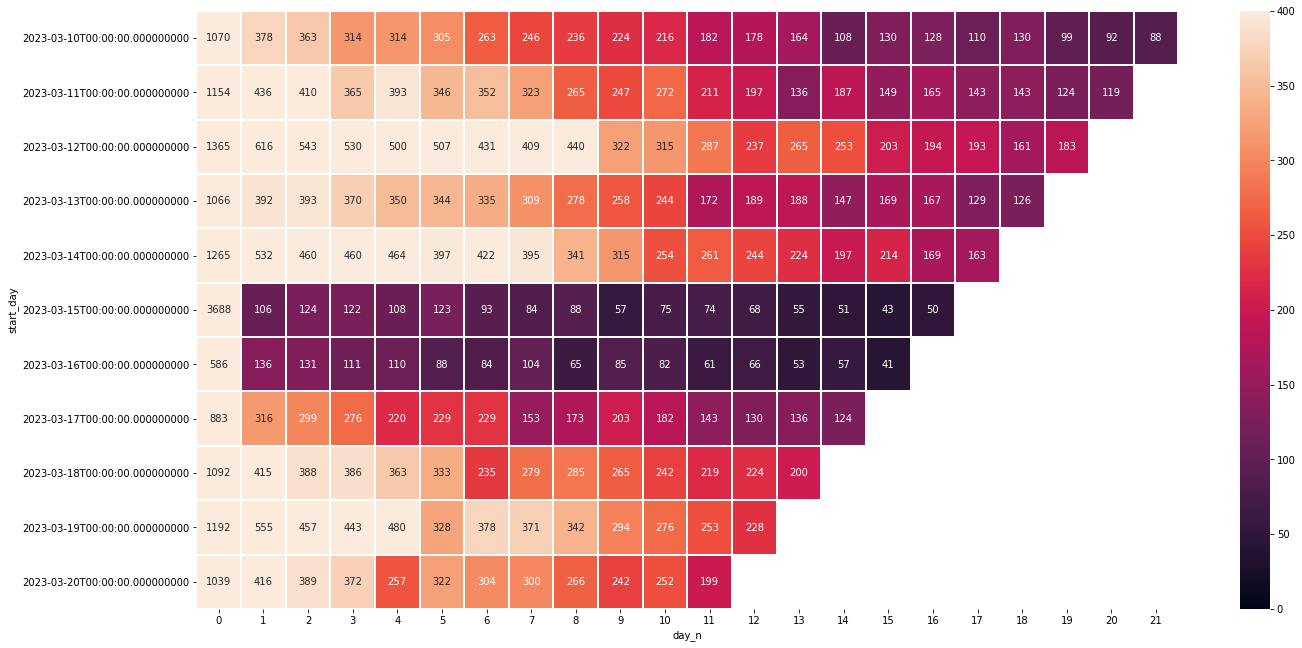

In [23]:
plt.rcParams['figure.figsize'] = [22, 11]
sns.heatmap(pivot, linewidth=.01, annot=True, fmt='g', vmin=0, vmax=400)

### Отобразим тепловую карту в процентах

In [24]:
pivot = pivot.divide(pivot[0], axis=0)

<AxesSubplot:xlabel='day_n', ylabel='start_day'>

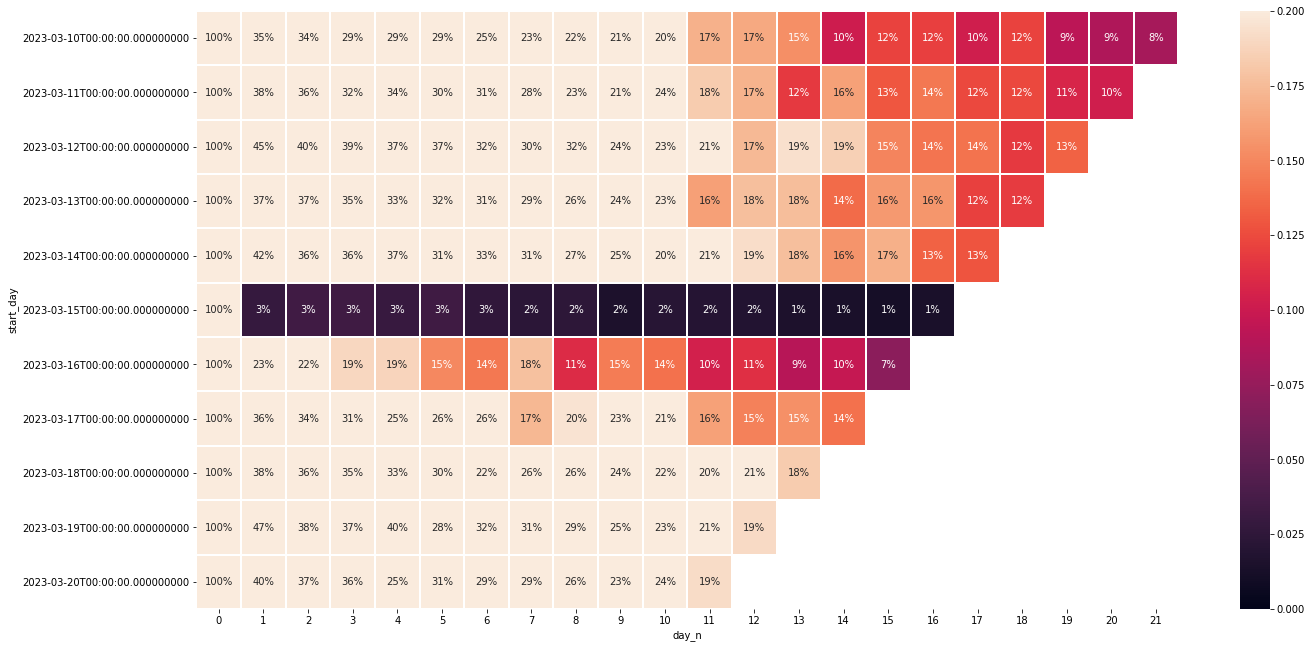

In [25]:
sns.heatmap(pivot, linewidth=.01, annot=True, fmt='.0%', vmin=0, vmax=0.20)

### Теперь смотрим ретеншн пользователей с каналом траффика "organic"

In [26]:
query2 = '''
SELECT 
    toString(start_day) start_day,
    toString(day) day,
    count(user_id) AS users
FROM
  (SELECT user_id,
          min(toDate(time)) AS start_day
    FROM simulator_20230320.feed_actions
    where source = 'organic'
    GROUP BY user_id
    HAVING toMonth(start_day) = 3 and (toDayOfMonth(start_day) BETWEEN 10 and 20)
    ) t1
  JOIN
    (SELECT DISTINCT user_id,
                      toDate(time) AS day
    FROM simulator_20230320.feed_actions
    where source = 'organic' and toMonth(time) < 4
    ) t2 
  USING user_id
GROUP BY start_day, day
'''

In [27]:
df2 = ph.read_clickhouse(query2, connection=connection)
df2['start_day'] = pd.to_datetime(df2['start_day'])
df2['day'] = pd.to_datetime(df2['day'])
df2['day_n'] = (df2['day'] - df2['start_day']).dt.days
pivot2 = df2.pivot_table(index='start_day', columns='day_n', values='users')

<AxesSubplot:xlabel='day_n', ylabel='start_day'>

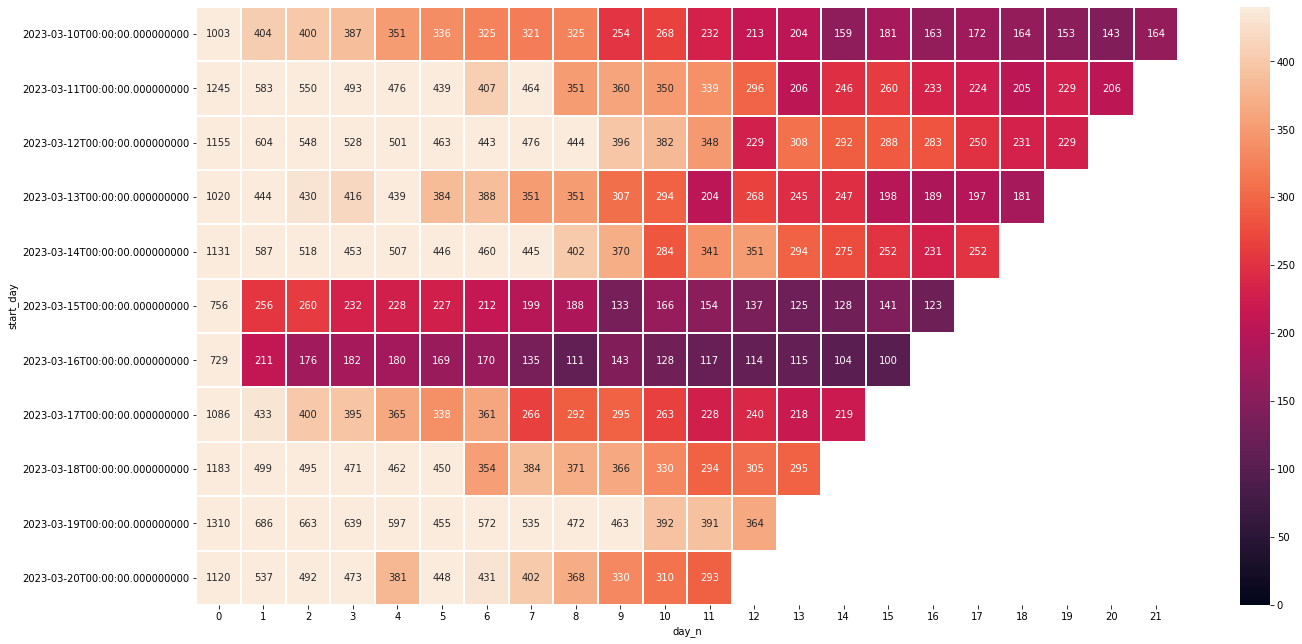

In [28]:
sns.heatmap(pivot2, linewidth=.01, annot=True, fmt='g', vmin=0, vmax=440)

<AxesSubplot:xlabel='day_n', ylabel='start_day'>

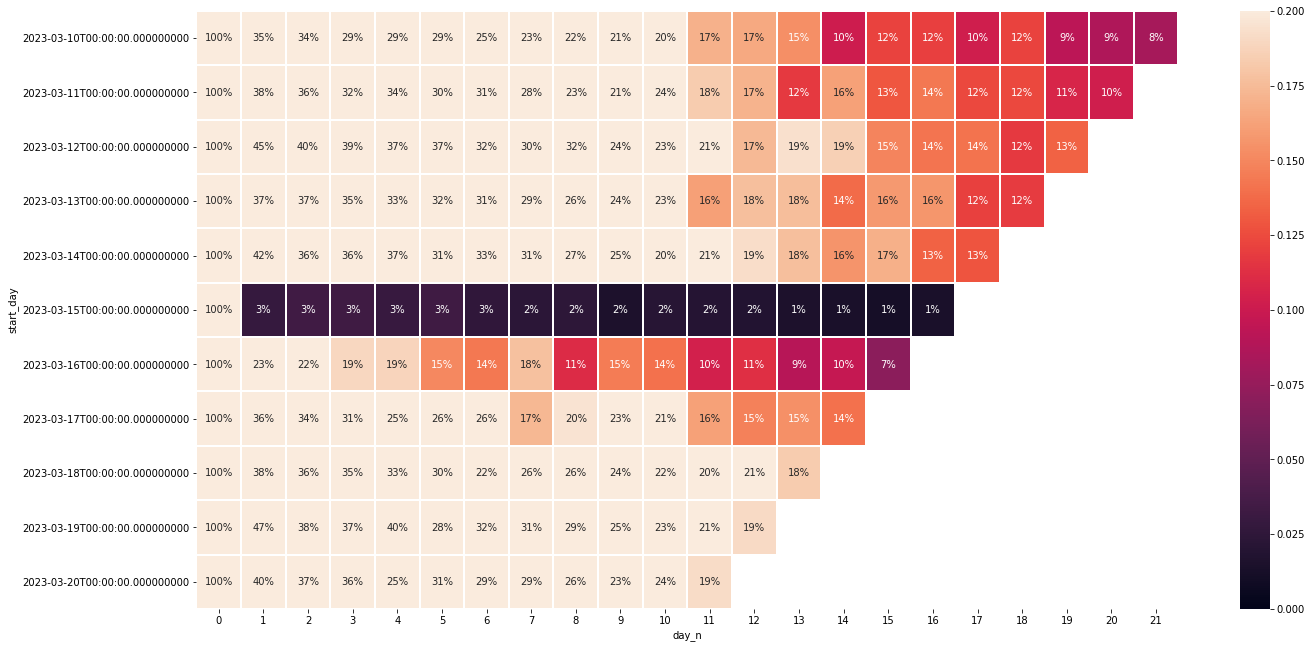

In [29]:
pivot2 = pivot2.divide(pivot2[0], axis=0)
sns.heatmap(pivot, linewidth=.01, annot=True, fmt='.0%', vmin=0, vmax=0.20)

# Вывод
Если посмотреть на процентный уровень возврата пользователей от разных источников траффика, то можно увидеть что возврат приблизительно одинаков

###

## Задание 2
### Маркетологи запустили массивную рекламную кампанию, в результате в приложение пришло довольно много новых пользователей, вы можете видеть всплеск активной аудитории 15 марта. 
### Однако у нас есть сомнение в качестве трафика, изучите, что стало с рекламными пользователями в дальнейшем, как часто они продолжают пользоваться приложением?

## Ответ
### На основе данных ретеншена по чарту можно посмотреть что количество пользователей, которые продолжили пользоваться приложением очень мало (пару процентов), поэтому можно сделать вывод что рекламная кампания была неудачной